In [1]:
# import packages
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

/Users/tanisipatel/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed = 2724

### Import data

In [4]:
DF_PATH = "mod04_data/sample.csv"
df = pd.read_csv(DF_PATH)

### Separate data by independent (X) and dependent (y) variables

In [5]:
X = df[["income", "education_years", "zipcode_score"]]
y = df["target"]

### Split the data into a _training_ set (to build a model) and _test_ set (to validate a model)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

### Build a model on the training set

In [7]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=seed
)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=2724)

### Use SHAP to explain the model on test data

In [8]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

 99%|===================| 1483/1500 [01:29<00:01]        

This will allow us to see which variables are most important to predicting the outcome.

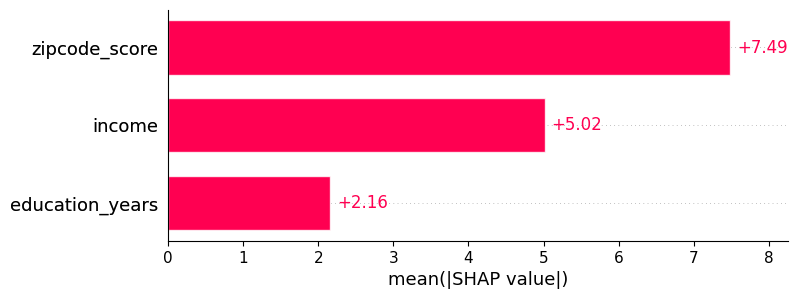

In [9]:
shap.plots.bar(shap_values)

### Import the `group` variable, which was **not** used in training this model.

In [10]:
X_test_with_group = X_test.copy()
X_test_with_group["group"] = df.loc[X_test.index, "group"]

### Look at the difference in SHAP values between the two groups across the variables used in the model.

In [11]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df["group"] = X_test_with_group["group"].values

shap_df.groupby("group").mean()

,income,education_years,zipcode_score
group,,,
0,1.085462,-0.172202,5.865217
1,1.019984,-0.193786,-6.860764


### Let's put `group` and `zipcode_score` in the same plot

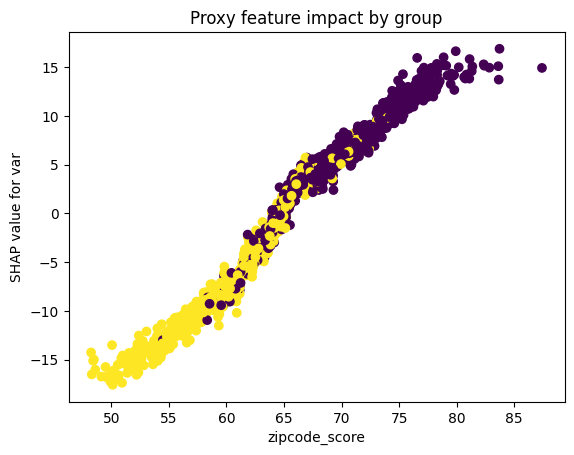

In [12]:
def plot_shap(var):
    # Extract SHAP values for the feature
    shap_var = shap_values[:, var].values

    # Plot the values of each group using different colors
    plt.figure()
    plt.scatter(
        X_test[var],
        shap_var,
        c=X_test_with_group["group"]
    )
    plt.xlabel(var)
    plt.ylabel(f"SHAP value for var")
    plt.title("Proxy feature impact by group")
    plt.show()

plot_shap("zipcode_score")

# Discussion Questions

### What is a _SHAP_ (or Shapley) value? 

A SHAP (Shapley) value measures how much a specific feature contributes to a single prediction compared to the model’s average prediction. The SHAP value measures the importance of a feature by comparing what a model predicts with that feature versus all input features (by averaging each features contribution across all possible feature combinations). This is a method that is rooted in game theory, used to explain machine learning model predictions by numericizing the contribution of each feature to the final output. SHAP explains individual predictions, such as why did the model deny this specific loan? A positive SHAP value indicated a feature increased the prediction value while the negative value show it decreased it. Essentially, SHAP explains the model’s behavior. 


### Suppose you built this model and then it is peer reviewed by another entity. If the reviewer asks whether you used the variable `group` in your model, what would your answer be?

If a reviewer asks if I used the group variable in my model, I would say no. the variable group was not used as an input feature in the model. Group was only used to examine potential disparate impact. Technically, group is not in the feature matrix and the model doesn’t put a condition on it.


### If the reviewer asks whether the outcome of your model is correlated with `group`, what would your answer be?

Based on the plot, yes it appears correlated. The SHAP values for zipcode_score differs systematically by group. The two groups occupy different regions of zipcode_score. Since zipcode_score strongly influence predictions, this creates an indirect relationship between group membership and model output. Even though group was not explicitly included, zipcode_score acts as a proxy causing indirect correlation between predictions and group.


### Construct a "proxy feature impact by group" plot for `income`. How is this plot different from the one for `zipcode_score`?

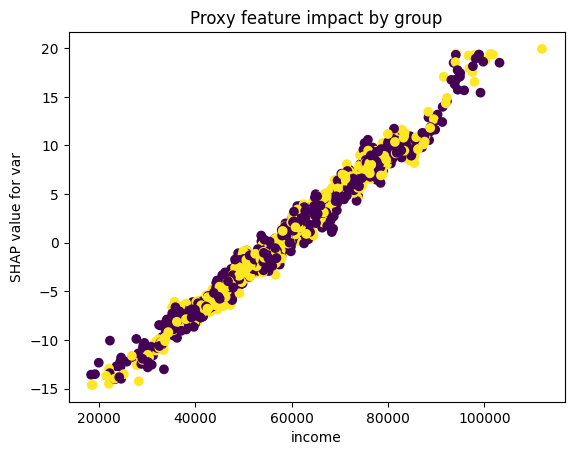

In [13]:
def plot_shap(var):
    # Extract SHAP values for the feature
    shap_var = shap_values[:, var].values

    # Plot the values of each group using different colors
    plt.figure()
    plt.scatter(
        X_test[var],
        shap_var,
        c=X_test_with_group["group"]
    )
    plt.xlabel(var)
    plt.ylabel(f"SHAP value for var")
    plt.title("Proxy feature impact by group")
    plt.show()

plot_shap("income")

The proxy feature impact plot for income shows lots of overlap between the two groups across all income levels. Unlike the zipcode_score plot, where the groups were separated along the feature axis, income doesn’t appear to be strongly correlated with group membership. Both groups follow a similar linear SHAP patter, suggesting that income isn’t a strong proxy for group compared in the way zipcode_score does. 


### If, instead, you were the **reviewer**, what other questions might you ask the person who built this model? Give at least two.


What is the correlation between each feature and group?
What happens to the model if zipcode_score was removed?